In [1]:
import torch 
import numpy as np
import pandas as pd 
from math import ceil
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
# Import necessary libraries and modules
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

In [3]:
import pandas as pd
import yfinance as yf

# Load your existing CSV file
input_file = 'Datasets/sp500_sentiment_non_weighted.csv'
output_file = 'Datasets/sp500_sentiment_updated.csv'
data = pd.read_csv(input_file)

# Convert the 'date' column in your existing data to datetime format and remove any timezone info
data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)

# Download S&P 500 data for the given timeframe
sp500 = yf.download("^GSPC", start="2010-01-01", end="2021-01-01")

# Flatten the MultiIndex columns in `sp500`
sp500.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in sp500.columns]

# Reset index to make 'Date' a column and rename it to 'date'
sp500.reset_index(inplace=True)
sp500.rename(columns={'Date': 'date'}, inplace=True)


# Select only the required columns
sp500 = sp500[['date', 'Low_^GSPC', 'High_^GSPC', 'Adj Close_^GSPC', 'Open_^GSPC']]
sp500.rename(columns={'Low_^GSPC': 'Low', 'High_^GSPC': 'High', 'Adj Close_^GSPC': 'Adj Close','Open_^GSPC': 'Open'}, inplace=True)

# Convert 'date' column in sp500 to datetime and remove timezone info
sp500['date'] = pd.to_datetime(sp500['date']).dt.tz_localize(None)

# Merge the financial data with the existing data
merged_data = pd.merge(data, sp500, on='date', how='left')

# Save the updated data to a new CSV file
merged_data.to_csv(output_file, index=False)
print(f"Updated data with 'Low', 'High', and 'Adj Close' saved to {output_file}")


[*********************100%***********************]  1 of 1 completed

Updated data with 'Low', 'High', and 'Adj Close' saved to Datasets/sp500_sentiment_updated.csv


In [4]:
data = pd.read_csv("Datasets/sp500_sentiment_updated.csv")
data = data.drop("Positive", axis='columns')
data = data.drop("Negative", axis='columns')
data = data.drop("Neutral", axis='columns')
data = data.drop("Price_change", axis='columns')
data = data.drop("Unnamed: 0", axis='columns')
data

,date,Volume,Close,Low,High,Adj Close,Open
0,2010-01-05,1.141819e+07,1136.520020,1129.660034,1136.630005,1136.520020,1132.660034
1,2010-01-06,1.078500e+07,1137.140015,1133.949951,1139.189941,1137.140015,1135.709961
2,2010-01-07,1.202273e+07,1141.689941,1131.319946,1142.459961,1141.689941,1136.270020
3,2010-01-08,1.621044e+07,1144.979980,1136.219971,1145.390015,1144.979980,1140.520020
4,2010-01-11,1.167700e+07,1146.979980,1142.020020,1149.739990,1146.979980,1145.959961
...,...,...,...,...,...,...,...
2612,2020-06-05,3.789298e+07,3193.929932,3163.840088,3211.719971,3193.929932,3163.840088
2613,2020-06-08,5.888138e+07,3232.389893,3196.000000,3233.129883,3232.389893,3199.919922
2614,2020-06-09,6.799510e+07,3207.179932,3193.110107,3222.709961,3207.179932,3213.320068
2615,2020-06-10,8.681144e+07,3190.139893,3181.489990,3223.270020,3190.139893,3213.419922


In [5]:
# Convert date column to a valid Datetime format
data["date"] = pd.to_datetime(data["date"])

# Check column types
data.dtypes

date         datetime64[ns]
Volume              float64
Close               float64
Low                 float64
High                float64
Adj Close           float64
Open                float64
dtype: object

In [6]:
# Define selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"

In [7]:
# Define start and end time for each period
#train_start_date = pd.to_datetime("2015-01-01")
train_end_date = pd.to_datetime("2018-12-31")
validate_start_date = pd.to_datetime("2019-01-01")
validate_end_date = pd.to_datetime("2020-01-31")
test_start_date = pd.to_datetime("2020-02-01")
test_end_date = pd.to_datetime("2020-06-11")

# Split dataset into training, validation, and testing
data_train = data[data["date"] <= train_end_date][features]
data_train_dates = data[data["date"] <= train_end_date]["date"]
data_validate = data[(data["date"] >= validate_start_date) & (data["date"] <= validate_end_date)][features]
data_validate_dates = data[(data["date"] >= validate_start_date) & (data["date"] <= validate_end_date)]["date"]
data_test = data[(data["date"] >= test_start_date) & (data["date"] <= test_end_date)][features]
data_test_dates = data[(data["date"] >= test_start_date) & (data["date"] <= test_end_date)]["date"]

In [8]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (2253, 6)
Validation Set: (273, 6)
Testing Set: (91, 6)


In [9]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
          Open         High          Low        Close    Adj Close  \
0  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020   
1  1135.709961  1139.189941  1133.949951  1137.140015  1137.140015   
2  1136.270020  1142.459961  1131.319946  1141.689941  1141.689941   
3  1140.520020  1145.390015  1136.219971  1144.979980  1144.979980   
4  1145.959961  1149.739990  1142.020020  1146.979980  1146.979980   

         Volume  
0  1.141819e+07  
1  1.078500e+07  
2  1.202273e+07  
3  1.621044e+07  
4  1.167700e+07  
Validation Dataset:
             Open         High          Low        Close    Adj Close  \
2253  2476.959961  2519.489990  2467.469971  2510.030029  2510.030029   
2254  2491.919922  2493.139893  2443.959961  2447.889893  2447.889893   
2255  2474.330078  2538.070068  2474.330078  2531.939941  2531.939941   
2256  2535.610107  2566.159912  2524.560059  2549.689941  2549.689941   
2257  2568.110107  2579.820068  2547.560059  2574.409912  2574.40991

In [10]:
import matplotlib.pyplot as plt


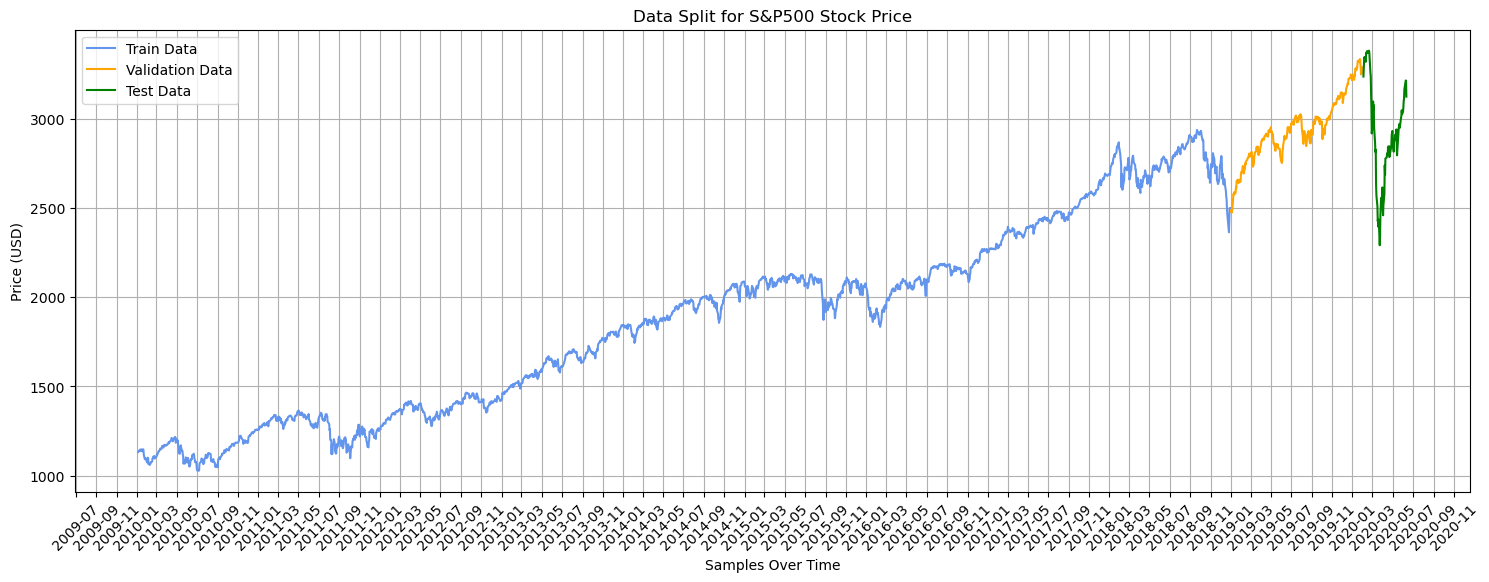

In [11]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for S&P500 Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

In [12]:
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,2617.000000,2617.000000,2617.000000,2617.000000,2617.000000,2.617000e+03
mean,2007.895731,2017.938651,1996.940471,2008.283040,2008.283040,4.550004e+07
std,615.260307,617.352782,612.772132,615.080920,615.080920,6.221001e+07
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,9.112000e+03
25%,1402.550049,1407.140015,1395.729980,1402.599976,1402.599976,1.084958e+07
50%,2018.979980,2029.609985,2005.550049,2019.640015,2019.640015,2.120185e+07
75%,2530.340088,2552.510010,2503.189941,2531.939941,2531.939941,6.033775e+07
max,3380.449951,3393.520020,3378.830078,3386.149902,3386.149902,1.278744e+09


In [13]:
from sklearn.preprocessing import MinMaxScaler


In [14]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

In [15]:
import joblib


In [16]:
# Prepare scaler model name and location
scaler_model_location = "models/"
scaler_model_name = "sp500_updated_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['models/sp500_updated_stock_price_scaler.gz']

In [17]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [18]:
# Prepare datasets files and location
data_file_location = "Datasets/"
data_file_name_train = "sp500_updated_stock_price_processed_train"
data_file_name_validate = "sp500_updated_stock_price_processed_validate"
data_file_name_test = "sp500_updated_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)

In [19]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [20]:
# Prepare datasets files and location
data_file_location = "Datasets/"
data_file_name_train = "sp500_updated_stock_price_processed_train"
data_file_name_validate = "sp500_updated_stock_price_processed_validate"
data_file_name_test = "sp500_updated_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [21]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (2253, 7)
Validation Dataset Shape: (273, 7)
Testing Dataset Shape: (91, 7)


In [22]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.055005  0.054341  0.061972  0.059712   0.059712  0.008922  2010-01-05
1  0.056602  0.055683  0.064210  0.060037   0.060037  0.008427  2010-01-06
2  0.056896  0.057396  0.062838  0.062421   0.062421  0.009395  2010-01-07
3  0.059122  0.058932  0.065395  0.064145   0.064145  0.012670  2010-01-08
4  0.061971  0.061212  0.068422  0.065193   0.065193  0.009125  2010-01-11
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.759155  0.779125  0.760129  0.779517   0.779517  0.039781  2019-01-02
1  0.766991  0.765315  0.747860  0.746951   0.746951  0.041502  2019-01-03
2  0.757777  0.788864  0.763709  0.790999   0.790999  0.014144  2019-01-04
3  0.789876  0.803586  0.789923  0.800301   0.800301  0.042249  2019-01-07
4  0.806900  0.810746  0.801926  0.813256   0.813256  0.059006  2019-01-08
Testing Dataset:
       Open      High       Low     Close  Ad

In [23]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [24]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [25]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [26]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [27]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [28]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [29]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [30]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (2617, 6)

 Data Train Scaled: (2253, 6)
> Data Train X: (2193, 60, 6)
> Data Train y: (2193,)

 Data Validate Scaled: (273, 6)
> Data Validate X: (273, 60, 6)
> Data Validate y: (273,)

 Data Test Scaled: (91, 6)
> Data Test X: (91, 60, 6)
> Data Test y: (91,)


In [31]:
# Initializing the model
regressor = Sequential()

In [32]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [33]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [34]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [35]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [36]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [37]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [38]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [39]:
import os

model_location = "models/"
if not os.path.exists(model_location):
    os.makedirs(model_location)


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Test ModelCheckpoint
try:
    test_callback = ModelCheckpoint("test_model.keras")
    print("ModelCheckpoint imported successfully.")
except Exception as e:
    print("Error with ModelCheckpoint:", e)

# Test load_model
try:
    # This will fail if there’s no model yet, but you’ll see if the function is available
    model = load_model("test_model.keras")
    print("load_model imported successfully.")
except Exception as e:
    print("load_model function is available, but no model to load:", e)


ModelCheckpoint imported successfully.
load_model function is available, but no model to load: File not found: filepath=test_model.keras. Please ensure the file is an accessible `.keras` zip file.


In [41]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "models/"
model_name = "sp500_updated_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=0)


In [42]:
# Training the model
history = regressor.fit(
    x = X_train, 
    y = y_train, 
    validation_data=(X_validate, y_validate), 
    epochs=200, 
    batch_size = 64, 
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 0.0450 - val_loss: 0.0088
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0019 - val_loss: 0.0118
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0023 - val_loss: 9.7313e-04
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━

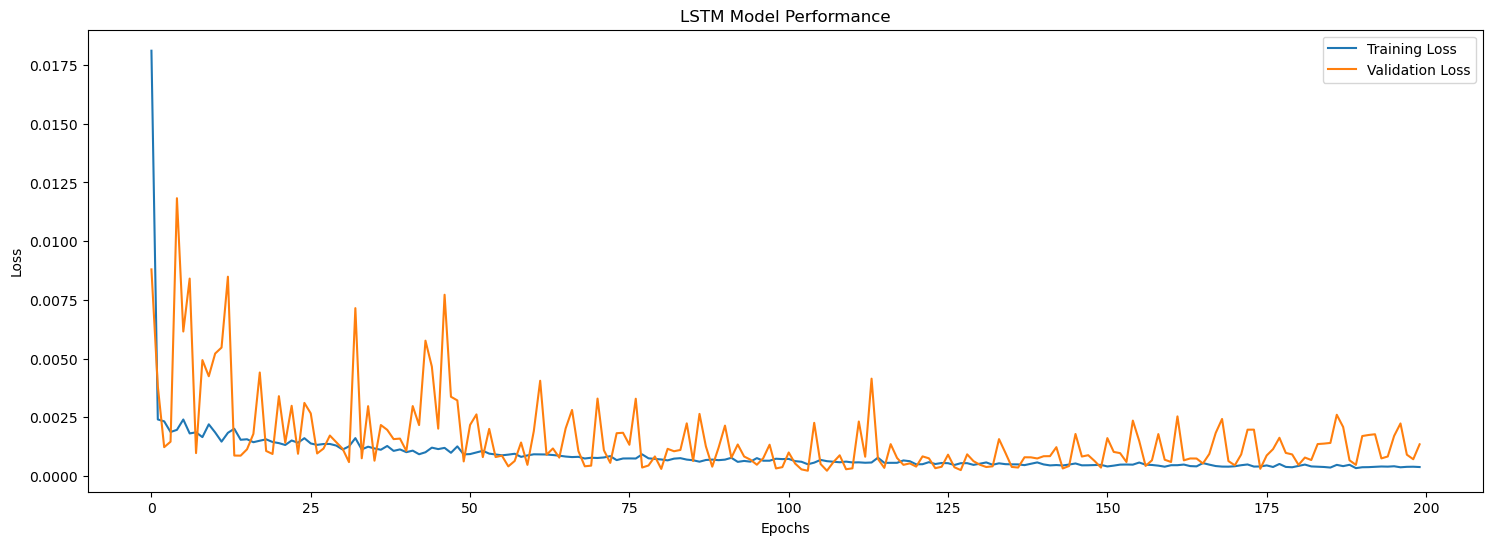

In [43]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [44]:
# Prepare model location and name
model_location = "models/"
model_name = "sp500_updated_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

In [45]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [46]:
# Prepare scaler model name and location
scaler_model_location = "models/"
scaler_model_name = "sp500_updated_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [47]:
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.ones((len(y_train.reshape(-1, 1)), 5))), axis=1))[:, 0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1, 1), np.ones((len(y_validate.reshape(-1, 1)), 5))), axis=1))[:, 0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.ones((len(y_test.reshape(-1, 1)), 5))), axis=1))[:, 0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:, 0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:, 0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:, 0]


In [48]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

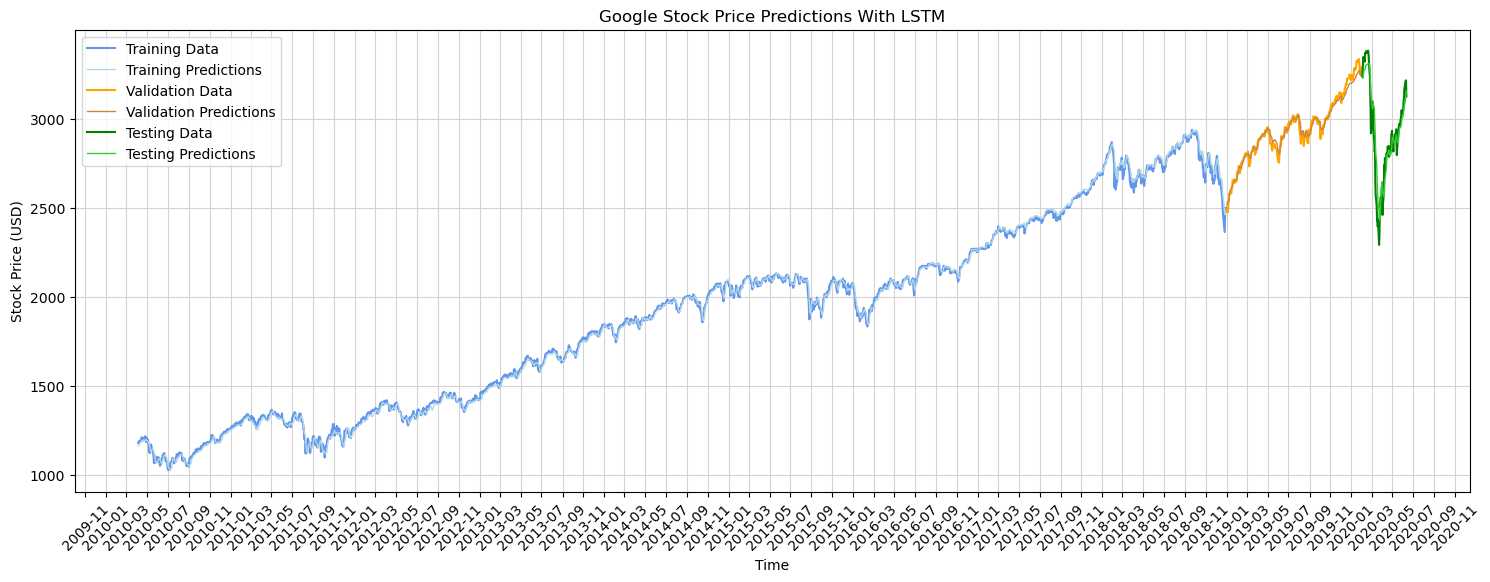

In [49]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

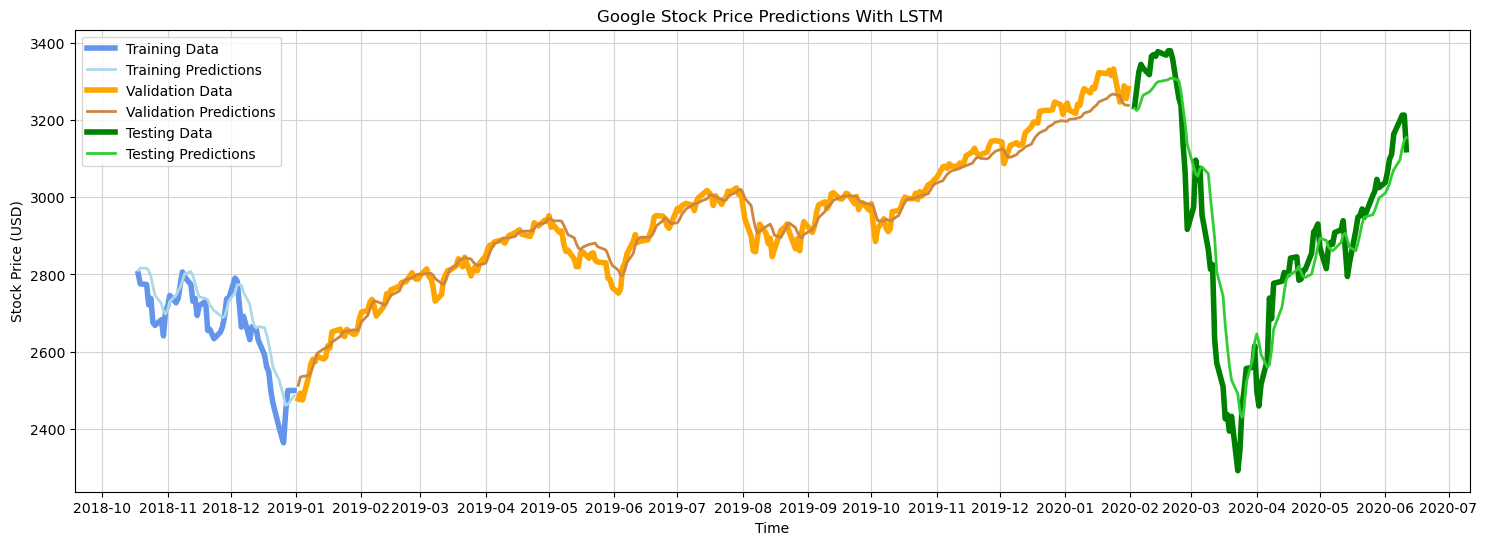

In [53]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Google Stock Price Predictions With LSTM ")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

In [51]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for test data
mse = mean_squared_error(y_test_inv, y_test_predict_inv)
mae = mean_absolute_error(y_test_inv, y_test_predict_inv)

print("Mean Square Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Square Error (MSE): 9361.342012968687
Mean Absolute Error (MAE): 75.34031128912797


In [52]:

import pandas as pd

# Adjust the dates to match the length of the actual and predicted values, assuming the predictions are shorter due to LSTM sequence requirements.
# The following code trims the date ranges to match the lengths of `y_train_inv`, `y_validate_inv`, and `y_test_inv`.

# Adjust training dates
adjusted_train_dates = data_train_dates[-len(y_train_inv):]

# Adjust validation dates
adjusted_validate_dates = data_validate_dates[-len(y_validate_inv):]

# Adjust test dates
adjusted_test_dates = data_test_dates[-len(y_test_inv):]

# Create side-by-side comparison DataFrames
comparison_train = pd.DataFrame({
    'Date': adjusted_train_dates,
    'Actual Value': y_train_inv.flatten(),
    'Predicted Value': y_train_predict_inv.flatten()
})

comparison_validate = pd.DataFrame({
    'Date': adjusted_validate_dates,
    'Actual Value': y_validate_inv.flatten(),
    'Predicted Value': y_validate_predict_inv.flatten()
})

comparison_test = pd.DataFrame({
    'Date': adjusted_test_dates,
    'Actual Value': y_test_inv.flatten(),
    'Predicted Value': y_test_predict_inv.flatten()
})

# Display the comparison DataFrames
print("Training Set Comparison:")
print(comparison_train)

print("\nValidation Set Comparison:")
print(comparison_validate)

print("\nTest Set Comparison:")
print(comparison_test)


Training Set Comparison:
           Date  Actual Value  Predicted Value
60   2010-04-05   1178.709961      1162.960990
61   2010-04-06   1186.010010      1165.423929
62   2010-04-07   1188.229980      1169.288128
63   2010-04-08   1181.750000      1173.223675
64   2010-04-09   1187.469971      1176.258190
...         ...           ...              ...
2248 2018-12-24   2400.560059      2524.514540
2249 2018-12-26   2363.120117      2483.310976
2250 2018-12-27   2442.500000      2460.383289
2251 2018-12-28   2498.770020      2462.913792
2252 2018-12-31   2498.939941      2485.011709

[2193 rows x 3 columns]

Validation Set Comparison:
          Date  Actual Value  Predicted Value
0   2019-01-02   2476.959961      2512.150376
1   2019-01-03   2491.919922      2533.630858
2   2019-01-04   2474.330078      2535.516389
3   2019-01-07   2535.610107      2537.330685
4   2019-01-08   2568.110107      2545.968167
..         ...           ...              ...
268 2020-01-27   3247.159912      32